In [ ]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import yfinance as yf
import matplotlib.pyplot as plt
yf.pdr_override()

In [ ]:
import pandas as pd
import yfinance as yf

start_date = '2020-01-01'
end_date = '2024-03-31'

data = data.get_data_yahoo('NVDA', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data_signal = pd.DataFrame(index=data.index)
data_signal['price'] = data['Adj Close']

In [ ]:
def MOMR_strategy_signals(financial_data, momentum_period, mean_reversion_period):
    # Create an empty DataFrame to store signals
    signals = pd.DataFrame(index=financial_data.index)
    signals['signal'] = 0  # Initialize signal column

    # Calculate momentum indicators (RSI)
    delta = financial_data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=momentum_period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=momentum_period).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))

    # Calculate mean reversion indicators (Bollinger Bands)
    MA = financial_data["Close"].rolling(window=mean_reversion_period).mean()
    Upper_band = MA + 2 * financial_data["Close"].rolling(window=mean_reversion_period).std()
    Lower_band = MA - 2 * financial_data["Close"].rolling(window=mean_reversion_period).std()

    short_ma = financial_data["Close"].rolling(window=15).mean()
    long_ma = financial_data["Close"].rolling(window=40).mean()

    # Adjust overbought and oversold thresholds based on moving averages
    if short_ma.iloc[-1] > long_ma.iloc[-1]:
        oversold_threshold = 40
        overbought_threshold = 90
    else:
        oversold_threshold = 30
        overbought_threshold = 70

    # Generate buy and sell signals
    buy_indices = financial_data["Close"][(RSI < oversold_threshold) & (financial_data["Close"] < Lower_band)].index
    sell_indices = financial_data["Close"][(RSI > overbought_threshold) & (financial_data["Close"] > Upper_band)].index

    # Update signals DataFrame with buy and sell signals
    signals.loc[buy_indices, 'signal'] = 1
    signals.loc[sell_indices, 'signal'] = -1

    # Update signals based on momentum and mean reversion
    for i in range(1, len(signals)):
        if RSI.iloc[i] < oversold_threshold and financial_data["Close"].iloc[i] < Lower_band.iloc[i]:
            signals['signal'].iloc[i] = 1
        elif RSI.iloc[i] > overbought_threshold and financial_data["Close"].iloc[i] > Upper_band.iloc[i]:
            signals['signal'].iloc[i] = 0
        else:
            signals['signal'].iloc[i] = signals['signal'].iloc[i - 1]

    # Calculate positions based on signal differences
    signals['positions'] = signals['signal'].diff().fillna(0)
    return signals


In [ ]:

momentum_period = 8
mean_reversion_period = 15


# Get trading signals
signals = MOMR_strategy_signals(data, momentum_period, mean_reversion_period)


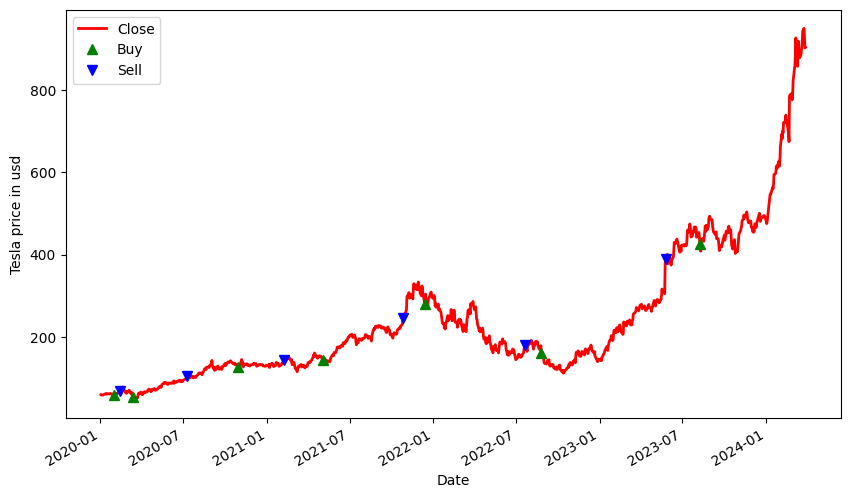

In [ ]:

# Plotting
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111, ylabel='Tesla price in usd')

data['Close'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(data.loc[signals.positions == 1.0].index, data['Close'][signals.positions == 1.0], '^', markersize=7, color='g', label='Buy')
ax1.plot(data.loc[signals.positions == -1.0].index, data['Close'][signals.positions == -1.0], 'v', markersize=7, color='b', label='Sell')

plt.legend()
plt.show()

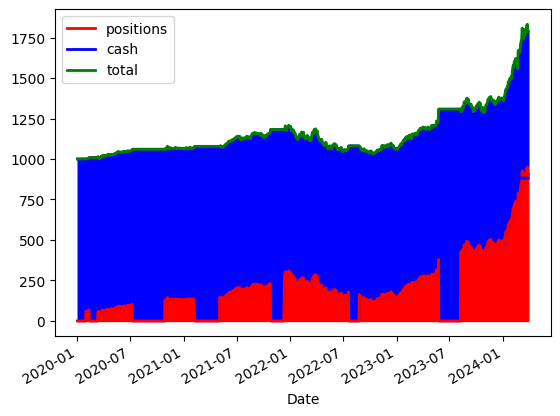

In [ ]:

# Initialize portfolio
initial_capital = float(1000.0)
positions = pd.DataFrame(index=data_signal.index).fillna(0.0)
portfolio = pd.DataFrame(index=data_signal.index).fillna(0.0)

# Update positions
positions['NVDA'] = signals['signal']

portfolio['positions'] = (positions.multiply(data_signal['price'], axis=0))
portfolio['cash'] = initial_capital - (positions.diff().multiply(data_signal['price'], axis=0)).cumsum()
portfolio['total'] = portfolio['positions'] + portfolio['cash']


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
portfolio['positions'].plot(ax=ax2, color = 'r', lw=2.)
ax2.fill_between(portfolio.index, portfolio['positions'], color ='r')
portfolio['cash'].plot(ax=ax2, color = 'b', lw=2.)
portfolio['total'].plot(ax=ax2, color = 'g', lw=2.)
ax2.fill_between(portfolio.index, portfolio['positions'], portfolio['total'], color ='b')

plt.legend()
plt.show()